now we group things by job titles 

percentage of one skill in a job

In [3]:
import pandas as pd
from datasets import load_dataset
import ast
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#loading data
df = load_dataset('lukebarousse/data_jobs')['train'].to_pandas()

#data clean up
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

df.describe()
df.info()
df.iloc[0:2]

job = ['Data Analyst']
country = ['United States']
##Data cleanup
#filter to US jobs
df_US = df[(df.job_country.isin(country)) & (df.job_title_short.isin(job))].copy()
#transition the str skills to list 
df_US['job_skills'] = df_US['job_skills'].apply(lambda skill: ast.literal_eval(skill) if pd.notna(skill) else skill)

#df_explode = df_US.explode('job_skills')
#capitalize the name of the skills 
#df_explode['job_skills']=df_explode['job_skills'].str.capitalize()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785741 entries, 0 to 785740
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   job_title_short        785741 non-null  object        
 1   job_title              785740 non-null  object        
 2   job_location           784696 non-null  object        
 3   job_via                785733 non-null  object        
 4   job_schedule_type      773074 non-null  object        
 5   job_work_from_home     785741 non-null  bool          
 6   search_location        785741 non-null  object        
 7   job_posted_date        785741 non-null  datetime64[ns]
 8   job_no_degree_mention  785741 non-null  bool          
 9   job_health_insurance   785741 non-null  bool          
 10  job_country            785692 non-null  object        
 11  salary_rate            33067 non-null   object        
 12  salary_year_avg        22003 non-null   floa

In [4]:
#we want to do this so we can exploide in the next block of code
df['job_skills'] = df['job_skills'].apply(lambda skill: ast.literal_eval(skill) if pd.notna(skill) else skill)


In [5]:

# Explode the job_skills column to have one skill per row
df_explodes = df.explode('job_skills')

# Group by job_title_short and job_skills
df_title = df_explodes.groupby(by=['job_skills', 'job_title_short']).agg(
    salary_avg=('salary_year_avg', 'median'),  # Count of job titles
    skill_count=('job_skills', 'count')      # Count of job skills
).reset_index()  # Optionally reset the index for a clean DataFrame


In [6]:
# Display the resulting DataFrame
df_title

,job_skills,job_title_short,salary_avg,skill_count
0,airflow,Business Analyst,89550.0,318
1,airflow,Cloud Engineer,136000.0,260
2,airflow,Data Analyst,111175.0,2002
3,airflow,Data Engineer,137280.0,25505
4,airflow,Data Scientist,157000.0,3915
...,...,...,...,...
2251,zoom,Machine Learning Engineer,89100.0,46
2252,zoom,Senior Data Analyst,150000.0,86
2253,zoom,Senior Data Engineer,165250.0,122
2254,zoom,Senior Data Scientist,180000.0,79


In [7]:
df_sql= df_title[df_title['job_skills'] == 'sql'].copy()


In [8]:
# Assuming df_sql is your DataFrame
sql_avg = df_sql['salary_avg'].mean()

# Create a new column 'pay_avg' based on the condition
df_sql['pay_avg'] = np.where(df_sql['salary_avg'] < sql_avg, False, True)

# Sort the DataFrame by 'skill_count'
df_sql = df_sql.sort_values('skill_count', ascending=False)

In [9]:
df_sql

,job_skills,job_title_short,salary_avg,skill_count,pay_avg
1822,sql,Data Engineer,125000.0,113130,True
1821,sql,Data Analyst,92500.0,92428,False
1823,sql,Data Scientist,132500.0,78982,True
1826,sql,Senior Data Engineer,147500.0,28594,True
1827,sql,Senior Data Scientist,157500.0,18605,True
1825,sql,Senior Data Analyst,111175.0,17709,False
1819,sql,Business Analyst,89100.0,17346,False
1828,sql,Software Engineer,98496.0,12341,False
1824,sql,Machine Learning Engineer,141000.0,3487,True
1820,sql,Cloud Engineer,116100.0,2227,False


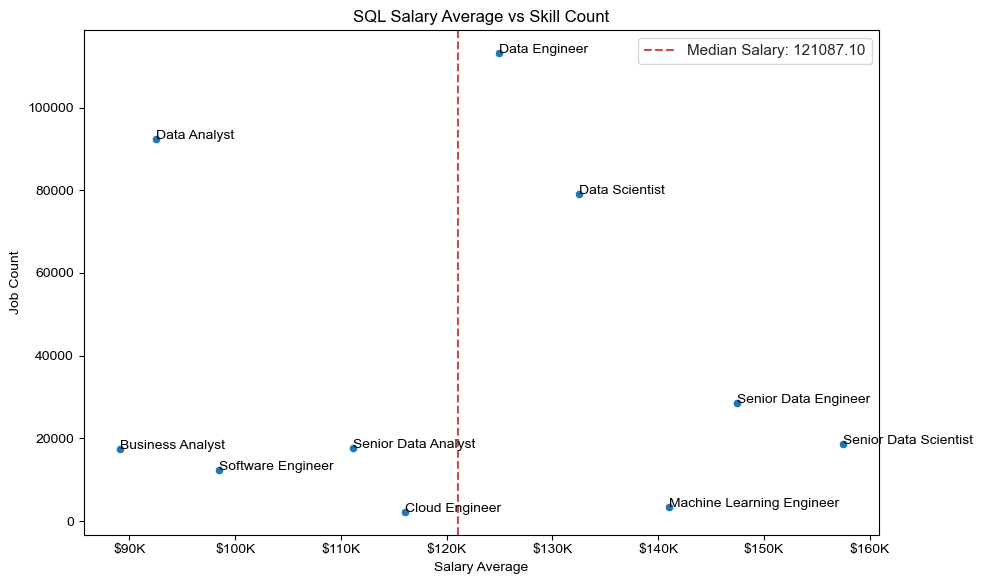

In [10]:
#ploting and formating

from matplotlib.ticker import FuncFormatter

# Function to format y-axis labels
def y_format(x, pos):
    return f'${int(x/1000)}K'

# Create a scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=df_sql, x='salary_avg', y='skill_count', ax=ax)

# Label the points with the names in 'job_title_short'
for i, txt in enumerate(df_sql['job_title_short']):
    ax.annotate(txt, (df_sql['salary_avg'].iloc[i], df_sql['skill_count'].iloc[i]))

# Set a white background with white grid
sns.set_theme(style="ticks")

# Draw a horizontal line for the median salary
ax.axvline(x=sql_avg, color='r', linestyle='--', label=f'Median Salary: {sql_avg:.2f}')

# Apply the custom y-axis formatter
ax.xaxis.set_major_formatter(FuncFormatter(y_format))

# Customize labels and title
ax.set_xlabel('Salary Average')
ax.set_ylabel('Job Count')
ax.set_title('SQL Salary Average vs Skill Count')

# Add legend for the median line
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


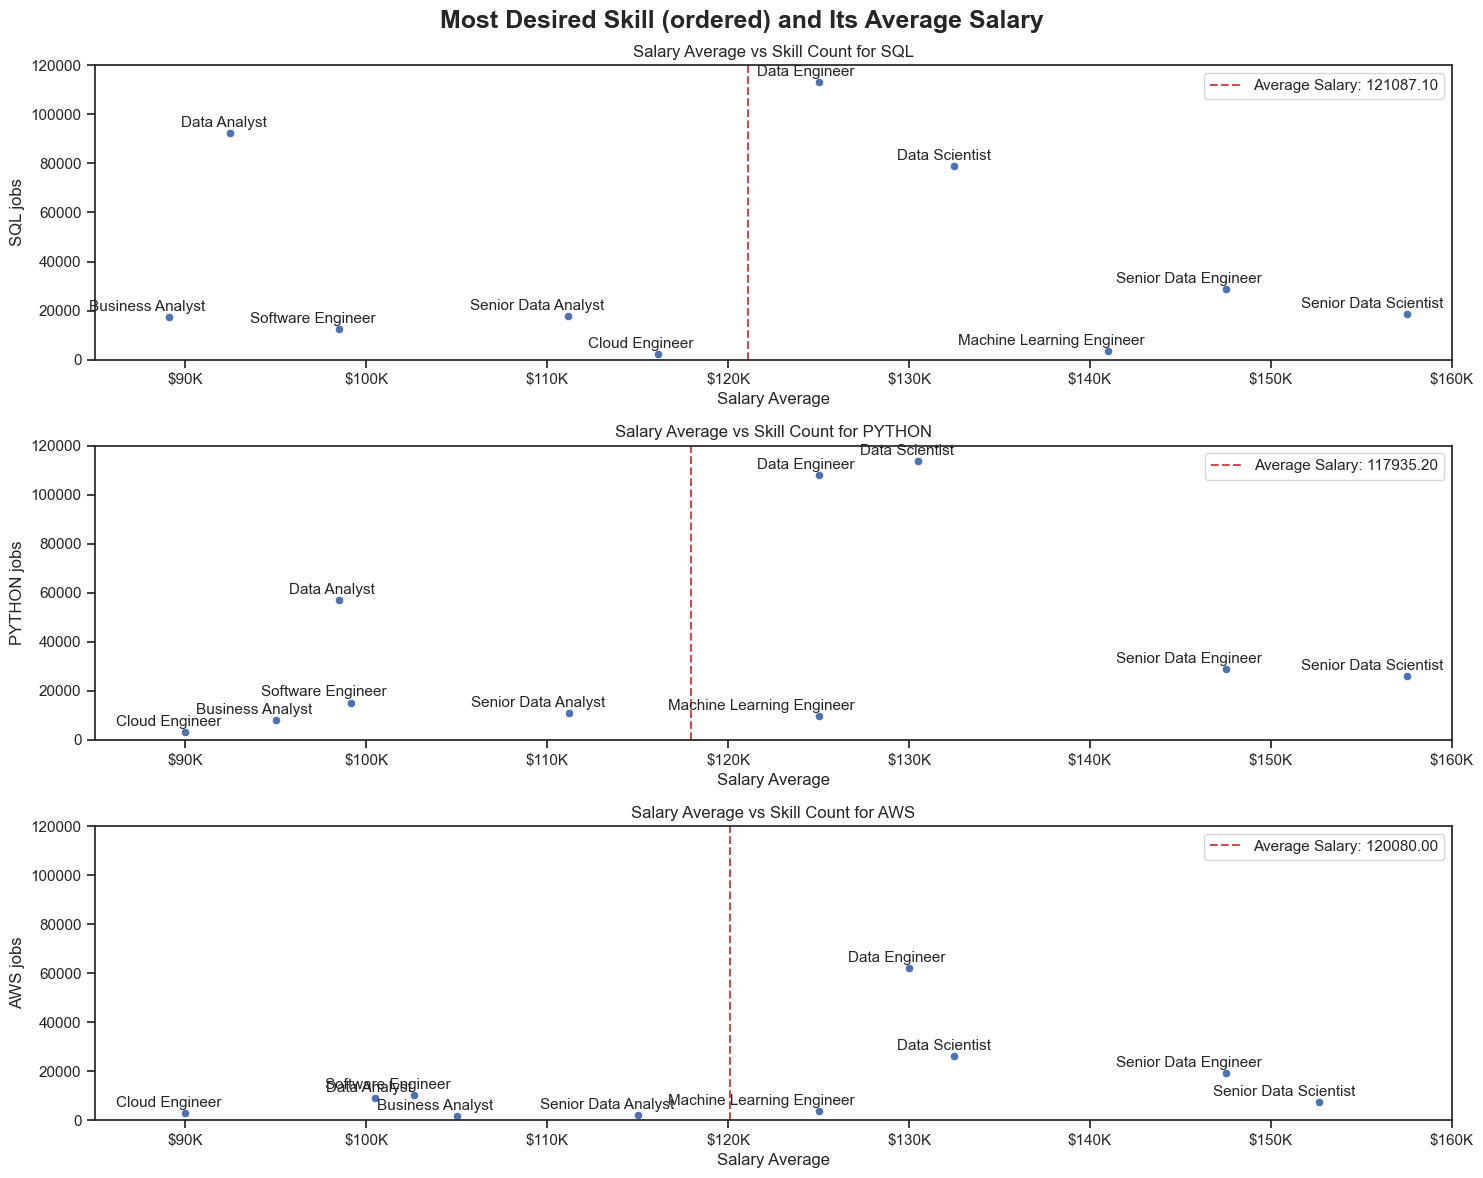

In [13]:
top_3 = df_explodes['job_skills'].value_counts().head(3).index.to_list()
#['sql', 'python', 'aws']

# Function to format y-axis labels
def y_format(x, pos):
    return f'${int(x/1000)}K'

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

for i, skill in enumerate(top_3):
    ax = axes[i]
    df_skill = df_title[df_title['job_skills'] == skill].copy()

    # Assuming df_sql is your DataFrame
    temp_avg = df_skill['salary_avg'].mean()   

    # Scatter plot on the subplot using Seaborn
    scatter_plot = sns.scatterplot(data=df_skill, x='salary_avg', y='skill_count', ax=ax)
    
    # Label the points with the names in 'job_title_short'
    for j, txt in enumerate(df_skill['job_title_short']):
        ax.annotate(txt, (df_skill['salary_avg'].iloc[j] + 2000, df_skill['skill_count'].iloc[j]+ 2500), fontsize=11, ha = 'right')
    
    #set ylim and xlim to be the same
    ax.set_xlim(85000,160000)
    ax.set_ylim(0,120000)

    # Set a white background with white grid
    sns.set_theme(style="ticks")
    
    # Draw a horizontal line for the median salary
    sql_avg = df_skill['salary_avg'].mean()
    ax.axvline(x=sql_avg, color='r', linestyle='--', label=f'Average Salary: {sql_avg:.2f}')
    
    # Apply the custom y-axis formatter
    ax.xaxis.set_major_formatter(FuncFormatter(y_format))
    
    # Customize labels and title
    ax.set_xlabel('Salary Average')
    ax.set_ylabel(f'{skill.upper()} jobs')
    ax.set_title(f'Salary Average vs Skill Count for {skill.upper()}')
    
    # Add legend for the median line
    ax.legend()

# Show the plot
plt.suptitle('Most Desired Skill (ordered) and Its Average Salary', fontsize = 18, fontweight='bold')
plt.tight_layout()
plt.show()

Next, will explore the jobs that is above the Average Salary and look to see what other skills are required

In [14]:
#crating the df that we will use to plot
#this is a panda portion

df_skills = df_explodes.copy()

skill_count = df_skills.groupby(by =['job_skills', 'job_title_short']).size()

#When you reset the index of a grouped object (like the result of groupby()), it converts the group keys 
# (which were previously used as the index) into regular columns.
df_skills_count = skill_count.reset_index(name = 'skill_count')
#type(df_skills_count)
#type(skill_count)

df_skills_count.sort_values(by= 'skill_count', ascending=False, inplace=True)


In [15]:
df_skills_count['job_skills']=df_skills_count.job_skills.str.capitalize()

In [16]:
#testing the equation
#df_skills_count[df_skills_count['job_title_short']=='Data Analyst']['skill_count'].sum()
df[df['job_title_short']=='Data Analyst']['job_title_short'].count()

196075

In [17]:
df_US.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67816 entries, 36 to 785705
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   job_title_short        67816 non-null  object        
 1   job_title              67816 non-null  object        
 2   job_location           67582 non-null  object        
 3   job_via                67809 non-null  object        
 4   job_schedule_type      67107 non-null  object        
 5   job_work_from_home     67816 non-null  bool          
 6   search_location        67816 non-null  object        
 7   job_posted_date        67816 non-null  datetime64[ns]
 8   job_no_degree_mention  67816 non-null  bool          
 9   job_health_insurance   67816 non-null  bool          
 10  job_country            67816 non-null  object        
 11  salary_rate            8442 non-null   object        
 12  salary_year_avg        4350 non-null   float64       
 13  sala

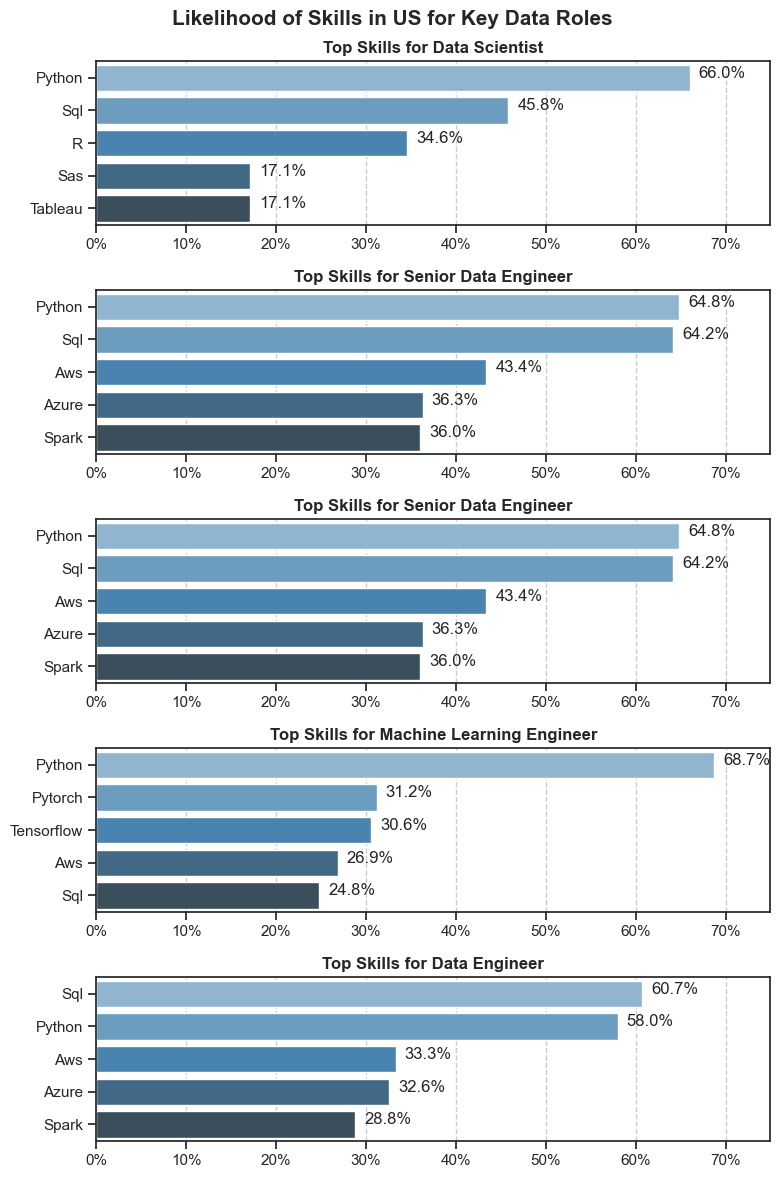

In [18]:
# List of job titles for which the top skills will be plotted
top_paying_jobs = ['Data Scientist', 'Senior Data Engineer', 'Senior Data Engineer', 'Machine Learning Engineer', 'Data Engineer']


# Set up the figure and axes for subplots
fig, ax = plt.subplots(len(top_paying_jobs), 1, figsize=(8, 12))

# Set the seaborn theme for cleaner visuals
sns.set_theme(style="ticks")

# Function to format y-axis labels
#can only format numbers, str value can not be formated
def x_format(x, pos):
    return f'{int(x)}%'


# Loop over each job title and generate a plot for the top 3 skills
for i, job_title in enumerate(top_paying_jobs):
        #sum of all the skills within the job 
    sum = df[df['job_title_short']==job_title]['job_title_short'].count()

    df_skills_count['changing pct'] = df_skills_count['skill_count']/sum * 100

    # Filter data for the current job title and get the top 3 skills
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)


    # Create a horizontal barplot using Seaborn, assigning hue to the y-axis (job_skills)
    sns.barplot(
        x='changing pct', 
        y='job_skills', 
        data=df_plot, 
        ax=ax[i], 
        hue='job_skills',  # Assign hue to y variable
        palette='Blues_d',  # Darker blue palette
        legend=False  # Disable legend
    )
    
    #Add labels
    for n, v in enumerate(df_plot['changing pct']):
        ax[i].text(v + 1, n, f'{v:.1f}%')

    # Apply the custom x-axis formatter
    ax[i].xaxis.set_major_formatter(FuncFormatter(x_format))
    # Apply the custom y-axis formatter
    #ax[i].yaxis.set_major_formatter(FuncFormatter(y_format))

    # Set the title for each subplot
    ax[i].set_title(f"Top Skills for {job_title}", fontsize=12, fontweight='bold')
    
    # Invert y-axis so the highest skill appears on top
    #ax[i].invert_yaxis()
    
    # Set consistent x-axis limits for all subplots
    ax[i].set_xlim(0,75)
    
    # Remove y-axis labels (to avoid clutter)
    ax[i].set_xlabel('')
    # Remove x-axis labels (to avoid clutter)
    ax[i].set_ylabel('')

    # Hide the grid to make it cleaner
    ax[i].grid(True, which='both', axis='x', linestyle='--')

# Add a universal title for the figure
fig.suptitle('Likelihood of Skills in US for Key Data Roles', fontsize=15, fontweight='bold')

# Add a common y-axis label
#fig.text(0.04, 0.5, 'Job Skills', va='center', rotation='vertical', fontsize=12)

# Adjust layout to prevent overlap and give space for titles
fig.tight_layout()

# Show the plot
plt.show()
